In [1]:
import scanpy, phate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scprep
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

In [2]:
sns.set(font_scale=1.5, style='white')

In [3]:
adata_acinar = scanpy.read_h5ad('data/adata_acinar.h5ad')
adata_acinar.obs['clusters'] = adata_acinar.obs['clusters'].map({0: 1, 1:3, 2:2})

In [4]:
markers = ['Cel', 'Cpa1', 'Ctrl', 'Pnlip', 'Cela3b', 'Cpb1', 'Ctrb1', 'Try4', 'Try5', 'Try10']

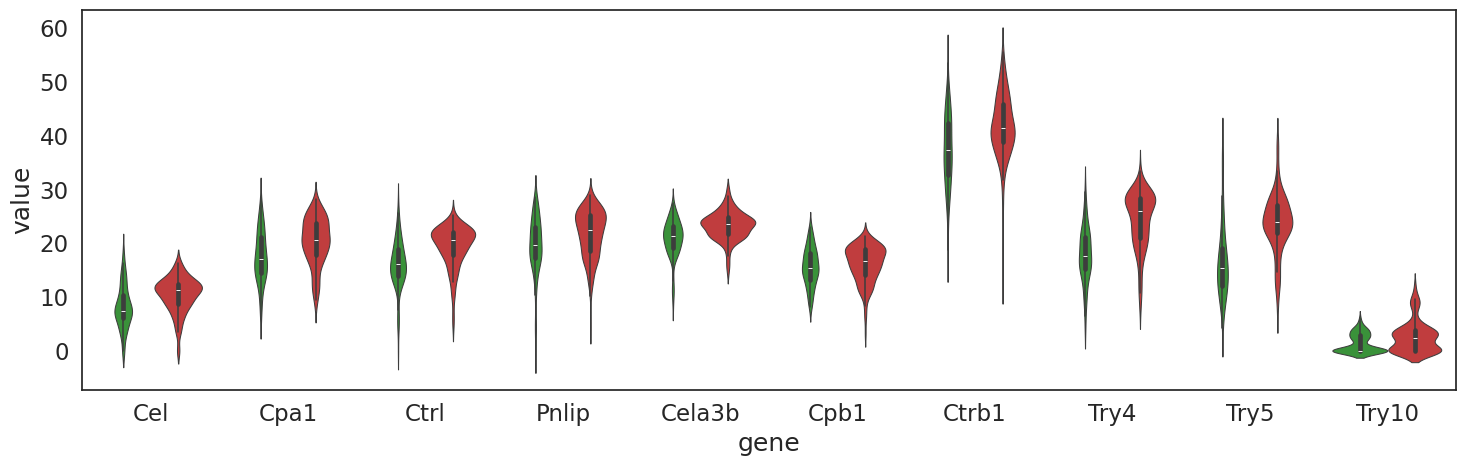

In [21]:
df = scanpy.get.obs_df(adata_acinar, markers + ['sample_group'])
df = df.set_index('sample_group').stack().reset_index()
df.columns = ['sample_group', 'gene', 'value']
fig = plt.figure(figsize=(15,5))
sns.violinplot(data=df, x='gene', y='value', hue="sample_group",  hue_order=['WT', 'HFD/OBOB'],
              palette=[plt.get_cmap("tab10")(i) for i in [2,3]], linewidth=0.75, legend=False)
plt.tight_layout()
fig.savefig('figures/protease_upregulation.png', dpi=500)

In [6]:
p_values = []
for marker in markers:
    x = df[(df['gene'] == marker) & (df['sample_group'] == 'WT')]['value'].values.flatten()
    y = df[(df['gene'] == marker) & (df['sample_group'] == 'HFD/OBOB')]['value'].values.flatten()
    p_values.append(ranksums(x, y, alternative='two-sided').pvalue)

rejected, p_adjusted, _, _ = multipletests(np.array(p_values), method='fdr_tsbky')
dict(zip(markers,p_adjusted))

{'Cel': 2.3918879868493535e-08,
 'Cpa1': 2.6619275838475643e-07,
 'Ctrl': 9.978994066380039e-12,
 'Pnlip': 0.00011452350224358522,
 'Cela3b': 1.9750610783991928e-09,
 'Cpb1': 0.012492648026632294,
 'Ctrb1': 4.987402467759313e-08,
 'Try4': 8.242109538105049e-19,
 'Try5': 5.861117383189032e-18,
 'Try10': 0.0001606737174724369}

/tmp/ipykernel_3003526/1149262841.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, y='value', x="clusters",  linewidth=0.75, legend=False,


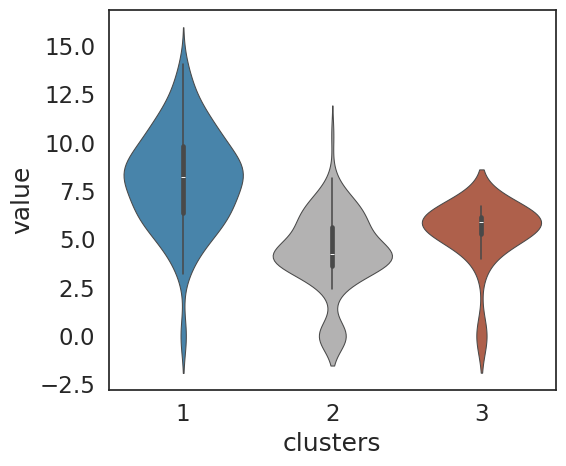

In [14]:
df = scanpy.get.obs_df(adata_acinar, ['Tff2'] + ['clusters'])
df = df.set_index('clusters').stack().reset_index()
df.columns = ['clusters', 'gene', 'value']

fig = plt.figure(figsize=(6,5))
sns.violinplot(data=df, y='value', x="clusters",  linewidth=0.75, legend=False, 
               order=[1,2,3],
               palette=['#3888ba', '#b3b2b2','#bf573a'])
plt.tight_layout()
fig.savefig('figures/tff2_violinplot.png', dpi=500)

In [19]:
x = df[(df['clusters'] == 1)]['value'].values.flatten()
y = df[(df['clusters'] == 2)]['value'].values.flatten()
print(ranksums(x, y, alternative='two-sided').pvalue)

x = df[(df['clusters'] == 1)]['value'].values.flatten()
y = df[(df['clusters'] == 3)]['value'].values.flatten()
print(ranksums(x, y, alternative='two-sided').pvalue)

3.298210481783951e-26
1.9042942569434475e-05


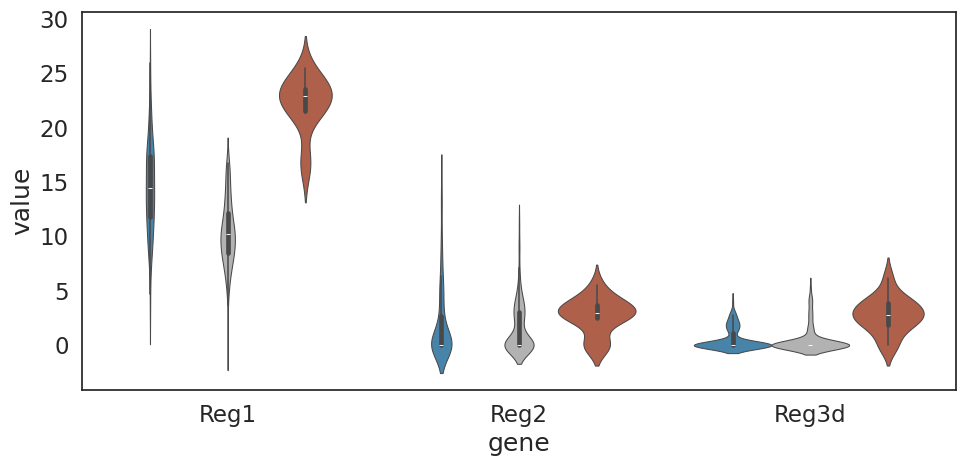

In [37]:
df = scanpy.get.obs_df(adata_acinar, ['Reg1', 'Reg2', 'Reg3d'] + ['clusters'])
df = df.set_index('clusters').stack().reset_index()
df.columns = ['clusters', 'gene', 'value']
fig = plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='gene', y='value', hue="clusters", hue_order=[1,2,3],
               palette=['#3888ba', '#b3b2b2','#bf573a'], linewidth=0.75, legend=False)
plt.tight_layout()
fig.savefig('figures/reg_upregulation.png', dpi=500)

In [38]:
p_values = []
for marker in ['Reg1', 'Reg2', 'Reg3d']:
    x = df[(df['gene'] == marker) & (df['clusters'] == 1)]['value'].values.flatten()
    y = df[(df['gene'] == marker) & (df['clusters'] == 3)]['value'].values.flatten()
    p_values.append(ranksums(x, y, alternative='two-sided').pvalue)

rejected, p_adjusted, _, _ = multipletests(np.array(p_values), method='fdr_tsbky')
dict(zip(['Reg1', 'Reg2', 'Reg3d'],p_adjusted))

{'Reg1': 1.1151581778226706e-07,
 'Reg2': 0.026319556828010467,
 'Reg3d': 4.8641742733729775e-06}

In [107]:
cluster_count = pd.read_csv('results/sample_cluster_count.csv')
cluster_count

,clusters,sample,count
0,1,WT,84
1,1,HFD/OBOB,37
2,3,HFD/OBOB,15
3,2,WT,33
4,2,HFD/OBOB,91


In [127]:
# Pivot the data: rows as 'sample', columns as 'clusters', and values as 'count'
pivot_df = df.pivot_table(index='sample', columns='clusters', values='count', aggfunc='sum', fill_value=0)
pivot_df = pivot_df.T / pivot_df.sum(axis=1)
pivot_df = 100*pivot_df.T
pivot_df = pivot_df.loc[['WT', 'HFD/OBOB']]

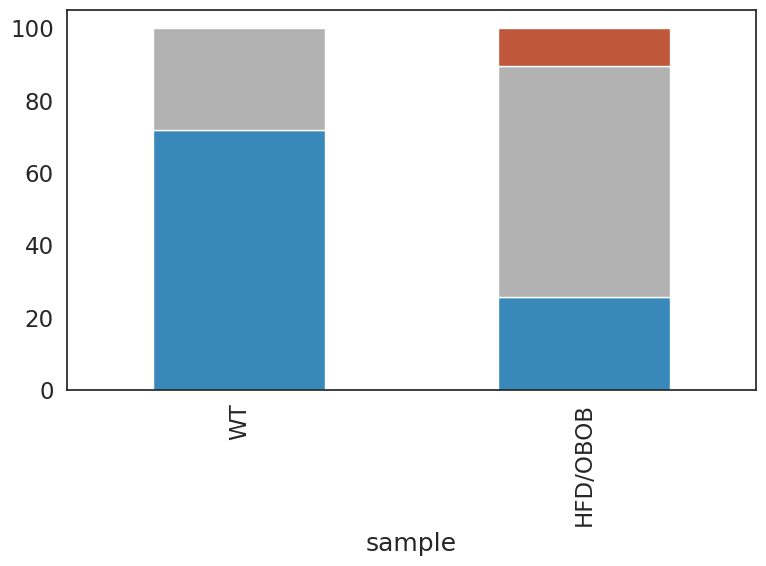

In [136]:
# Plotting
fig,ax = plt.subplots(figsize=(8, 6))
pivot_df.plot(kind='bar', stacked=True, ax=ax,
              color=['#3888ba', '#b3b2b2','#bf573a'],legend=False)
plt.tight_layout()
fig.savefig('figures/cluster_proportions.png', dpi=500)